In [40]:
import torch
import torchvision
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import TensorDataset, DataLoader 
import copy

In [41]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dataset = torchvision.datasets.FashionMNIST(root='datasets')

images = torch.tensor(dataset.data).float()
images = torch.reshape(input=images, shape=[60000, 1, 28, 28])
images = images/torch.max(images)
labels = torch.tensor(copy.deepcopy(dataset.targets))

C:\Users\NISHIT\AppData\Local\Temp\ipykernel_15480\3845542265.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(dataset.data).float()
C:\Users\NISHIT\AppData\Local\Temp\ipykernel_15480\3845542265.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(copy.deepcopy(dataset.targets))


In [42]:
train_data, test_data, train_label, test_label = train_test_split(images, labels, test_size = .1)
dev_data, test_data, dev_label, test_label = train_test_split(test_data, test_label, test_size= .5)

train_dataset = TensorDataset(train_data, train_label)
dev_dataset = TensorDataset(dev_data, dev_label)
test_dataset = TensorDataset(test_data, test_label)

batch_size = 32

train_data_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, drop_last = True, shuffle = True)
dev_data_loader = DataLoader(dataset = dev_dataset, batch_size = dev_label.shape[0])
test_data_loader = DataLoader(dataset = test_dataset, batch_size = test_label.shape[0])

In [43]:
class FashionMNISTClassifier(nn.Module):

    def __init__(self):

        super().__init__()
        self.convolution_layer_1 = nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, padding=1)
        self.batch_norm_1 = nn.BatchNorm2d(128)

        # output size: (28 + 2*(1) - 3)/1 + 1 = 28 ; 28/2 = 14 (2x2 kernal max pooling effect)

        self.convolution_layer_2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.batch_norm_2 = nn.BatchNorm2d(256)

        # output size: (14 + 2*(1) - 3)/1 + 1 = 14 ; 14/2 = 7 (2x2 kernal max pooling effect)

        self.fully_connected_layer_1 = nn.Linear(7*7*256, 128)
        self.batch_norm_1D_1 = nn.BatchNorm1d(128)
        self.output_layer = nn.Linear(128, labels.unique().shape[0])
    
    def forward(self, x):
        
        x = F.max_pool2d(self.convolution_layer_1(x), 2)
        x = F.leaky_relu(self.batch_norm_1(x))
        fm1 = x

        x = F.max_pool2d(self.convolution_layer_2(x), 2)
        x = F.leaky_relu(self.batch_norm_2(x))
        fm2 = x

        num_elements = int(x.shape.numel() / x.shape[0])
        x = x.view(-1, num_elements)
        
        x = F.leaky_relu(self.batch_norm_1D_1(self.fully_connected_layer_1(x)))

        return self.output_layer(x), fm1, fm2


In [44]:
classifier = FashionMNISTClassifier()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr = .001, weight_decay=1e-5)

classifier.to(device)
num_epochs = 10

for epoch_i in range(num_epochs):
    
    for X, y in train_data_loader:
        
        X = X.to(device)
        y = y.to(device)

        preds = classifier(X)
        loss = loss_function(preds[0], y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 

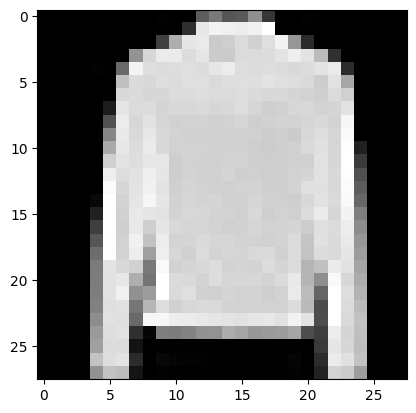

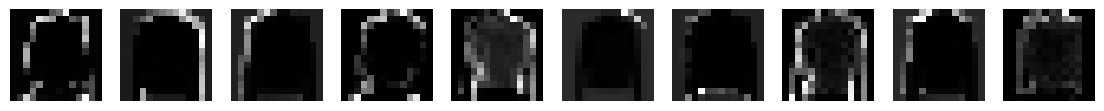

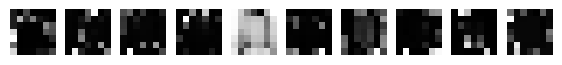

Devset Accuracy = 93.23333740234375 %


In [45]:
X, y = next(iter(dev_data_loader))

X = X.to(device)
y = y.to(device)

preds = classifier(X)

img_index = 3

fm1 = preds[1][img_index].cpu().detach().numpy()
fm2 = preds[2][img_index].cpu().detach().numpy()

img = X[img_index].cpu().detach().numpy()
img = np.transpose(img, (1,2,0))
plt.imshow(img, cmap='gray')


fig, axes = plt.subplots(1, 10, figsize=(14, 14))  
for i in range(10):
    axes[i].imshow(fm1[i], cmap='gray')
    axes[i].axis('off')  
plt.show()

fig, axes = plt.subplots(1, 10, figsize=(7, 7))  
for i in range(10):
    axes[i].imshow(fm2[i], cmap='gray')
    axes[i].axis('off')  
plt.show()

preds = torch.argmax(preds[0], dim=1)
result = (preds == y).float()
accuracy = ((torch.sum(result) / result.shape[0]) * 100).item()
print("Devset Accuracy = "+ str(accuracy) + " %")